# Importing The libraries

In [1]:
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
IMG_CHANNELS = 3
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [3]:
images_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
mask_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"

In [4]:
img_ids = next(os.walk(images_path))[2]
mask_ids = next(os.walk(mask_path))[2]

In [5]:
X = np.zeros((len(img_ids), 256, 256, 3), dtype=np.uint8)
y = np.zeros((len(mask_ids), 256, 256, 1), dtype=np.bool_)

In [6]:
for n,img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image

In [7]:
for n,mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

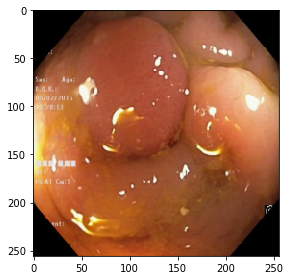

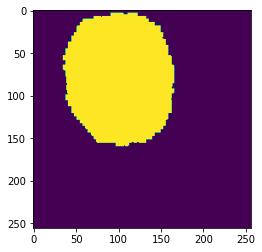

In [8]:
image_random = random.randint(0, len(X))
imshow(X[image_random])
plt.show()
plt.imshow(np.squeeze(y[image_random]))


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
print(f"X_train.shape: {X_train.shape}\nY_train.shape: {y_train.shape}")

X_train.shape: (670, 256, 256, 3)
Y_train.shape: (670, 256, 256, 1)


In [11]:
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

model = tf.keras.Model(inputs=input, outputs=outputs, name='U-NET')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','iou_coef'])

In [12]:
# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef])

model.summary()

Model: "U-NET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
______________________________________________________________________________________________

# Training the model.

In [14]:
model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=100)

Epoch 1/100
76/76 [==============================] - 16s 78ms/step - loss: 0.5202 - accuracy: 0.8265 - iou_coef: 0.1153 - val_loss: 0.4228 - val_accuracy: 0.8206 - val_iou_coef: 0.1313
Epoch 2/100
76/76 [==============================] - 5s 63ms/step - loss: 0.4249 - accuracy: 0.8272 - iou_coef: 0.1311 - val_loss: 0.4155 - val_accuracy: 0.8206 - val_iou_coef: 0.1432
Epoch 3/100
76/76 [==============================] - 5s 62ms/step - loss: 0.4024 - accuracy: 0.8273 - iou_coef: 0.1435 - val_loss: 0.4069 - val_accuracy: 0.8206 - val_iou_coef: 0.1362
Epoch 4/100
76/76 [==============================] - 5s 62ms/step - loss: 0.3976 - accuracy: 0.8273 - iou_coef: 0.1492 - val_loss: 0.3882 - val_accuracy: 0.8206 - val_iou_coef: 0.1578
Epoch 5/100
76/76 [==============================] - 5s 62ms/step - loss: 0.3957 - accuracy: 0.8273 - iou_coef: 0.1550 - val_loss: 0.4068 - val_accuracy: 0.8206 - val_iou_coef: 0.1354
Epoch 6/100
76/76 [==============================] - 5s 62ms/step - loss: 0.380

## PREDICTED IMAGE:

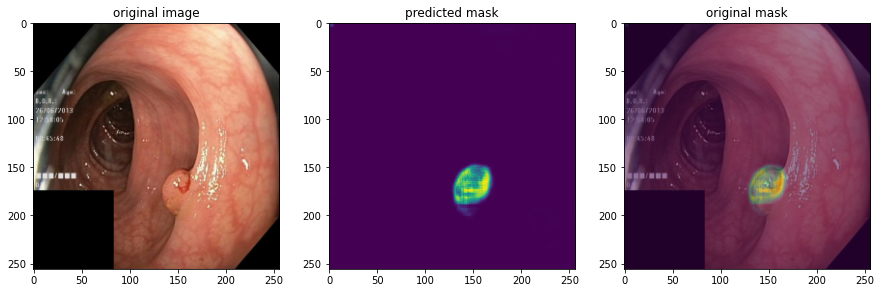

In [15]:
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.title("original image")
plt.imshow(np.squeeze(img))
plt.subplot(1, 3, 2)
plt.title("predicted mask")
plt.imshow(np.squeeze(predictions))
plt.subplot(1, 3, 3)
plt.title("original mask")
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.show()

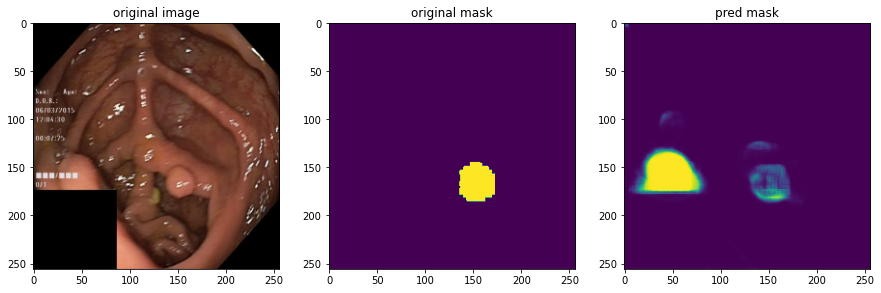

In [16]:
ind = random.randint(0, len(X_test))
img = X_test[ind]
predMask = model.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image")
ax1.imshow(X_test[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask")
ax2.imshow(np.squeeze(y_test[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask")
ax3.imshow(np.squeeze(predMask))


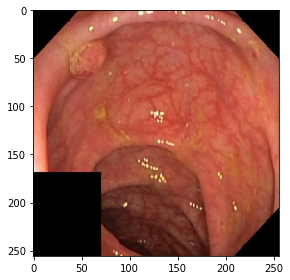

X_train.shape: (670, 256, 256, 3)
Y_train.shape: (670, 256, 256, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________

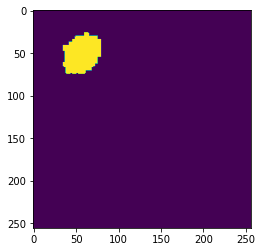

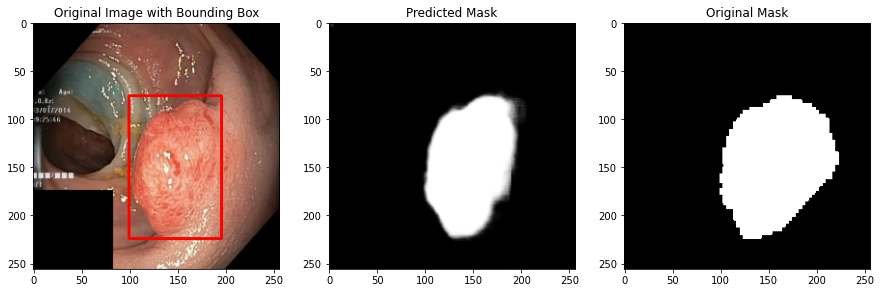

In [1]:
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
IMG_CHANNELS = 3
IMG_WIDTH = 256
IMG_HEIGHT = 256
images_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
mask_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"
img_ids = next(os.walk(images_path))[2]
mask_ids = next(os.walk(mask_path))[2]
X = np.zeros((len(img_ids), 256, 256, 3), dtype=np.uint8)
y = np.zeros((len(mask_ids), 256, 256, 1), dtype=np.bool_)
for n,img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image
for n,mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask
image_random = random.randint(0, len(X))
imshow(X[image_random])
plt.show()
plt.imshow(np.squeeze(y[image_random]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"X_train.shape: {X_train.shape}\nY_train.shape: {y_train.shape}")
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

model = tf.keras.Model(inputs=[input], outputs=[outputs])

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef])
model.summary()
model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=100)

# Function to draw bounding box
def draw_bounding_box(image, mask):
    # Convert mask to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding box for each contour
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    return image

# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image
img_with_box = draw_bounding_box(np.copy(img), pred_mask)

plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.title("Original Image with Bounding Box")
plt.imshow(img_with_box)
plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Original Mask")
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.show()


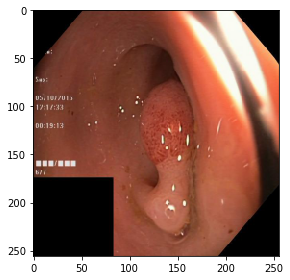

X_train.shape: (670, 256, 256, 3)
Y_train.shape: (670, 256, 256, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_34[0][0]                  
________________________

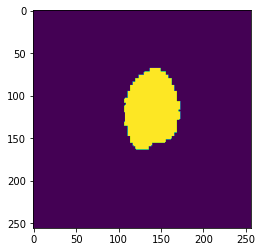

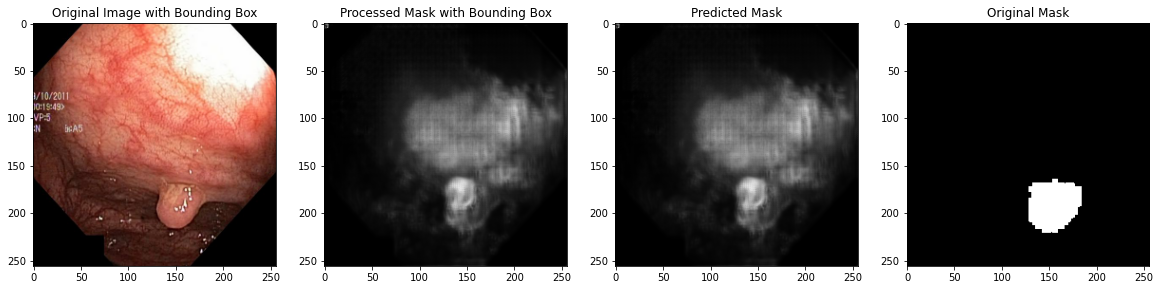

In [2]:
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
IMG_CHANNELS = 3
IMG_WIDTH = 256
IMG_HEIGHT = 256
images_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
mask_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"
img_ids = next(os.walk(images_path))[2]
mask_ids = next(os.walk(mask_path))[2]
X = np.zeros((len(img_ids), 256, 256, 3), dtype=np.uint8)
y = np.zeros((len(mask_ids), 256, 256, 1), dtype=np.bool_)
for n,img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image
for n,mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask
image_random = random.randint(0, len(X))
imshow(X[image_random])
plt.show()
plt.imshow(np.squeeze(y[image_random]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"X_train.shape: {X_train.shape}\nY_train.shape: {y_train.shape}")
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

model = tf.keras.Model(inputs=[input], outputs=[outputs])

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef])
model.summary()
model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=100)

# Function to draw bounding box
def draw_bounding_box(image, mask):
    # Convert mask to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding box for each contour
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, f"W:{w}, H:{h}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    return image

# Function to draw bounding box on mask
def draw_bounding_box_on_mask(mask):
    # Convert mask to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding box for each contour
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        mask = cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(mask, f"W:{w}, H:{h}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return mask

# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask(np.copy(pred_mask))

plt.figure(figsize=(20, 12))
plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box")
plt.imshow(img_with_box)
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box")
plt.imshow(mask_with_box, cmap='gray')
plt.subplot(1, 4, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')
plt.subplot(1, 4, 4)
plt.title("Original Mask")
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.show()


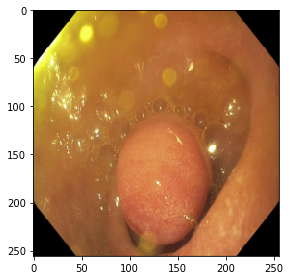

X_train.shape: (670, 256, 256, 3)
Y_train.shape: (670, 256, 256, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________

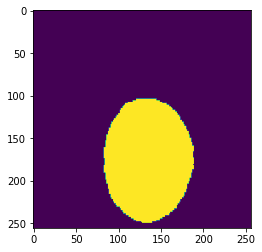

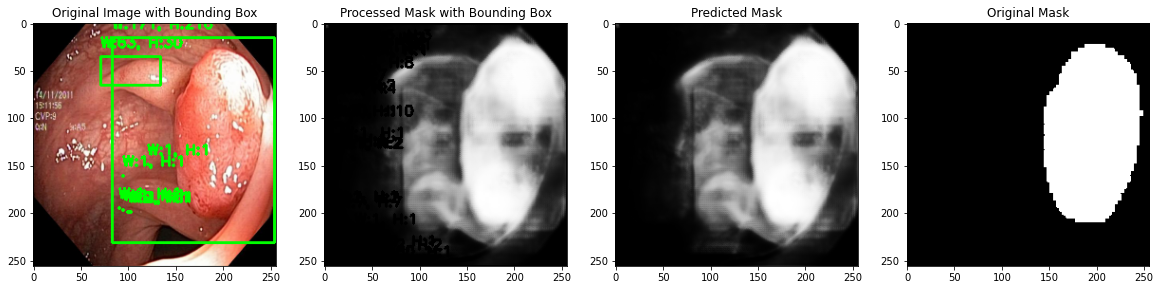

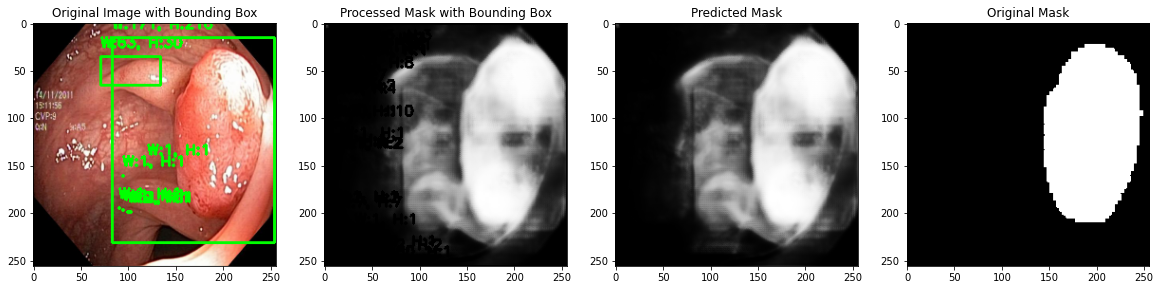

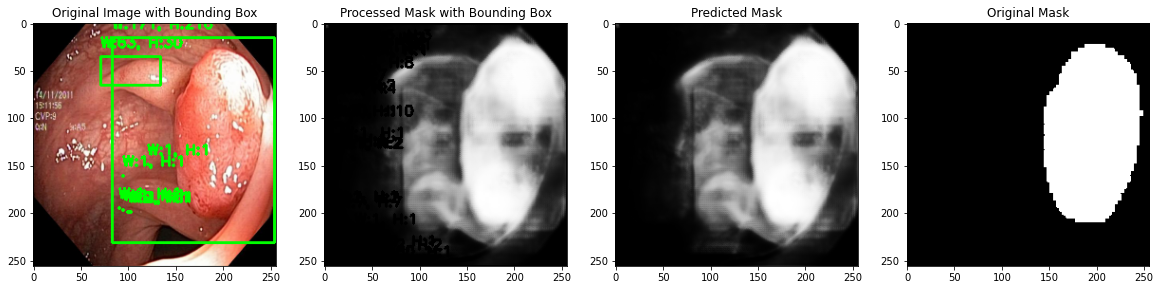

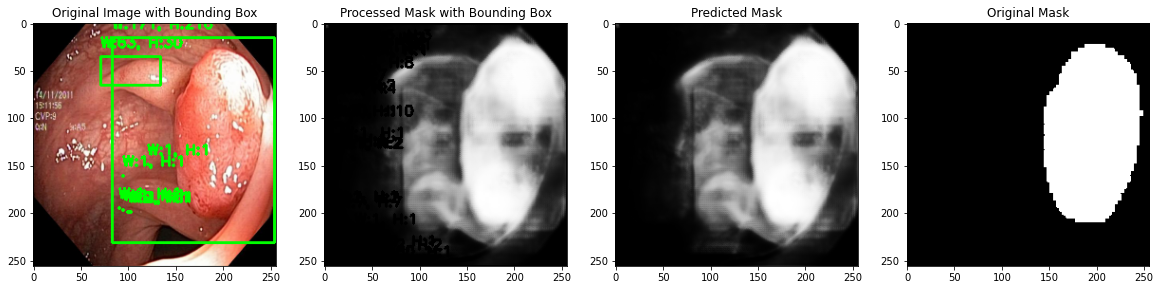

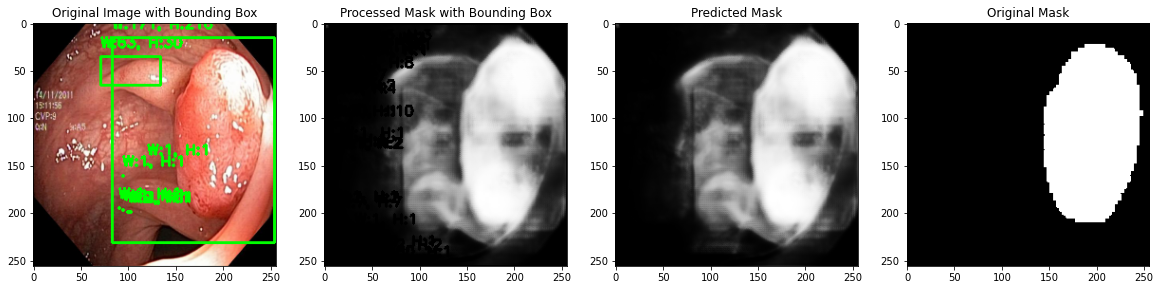

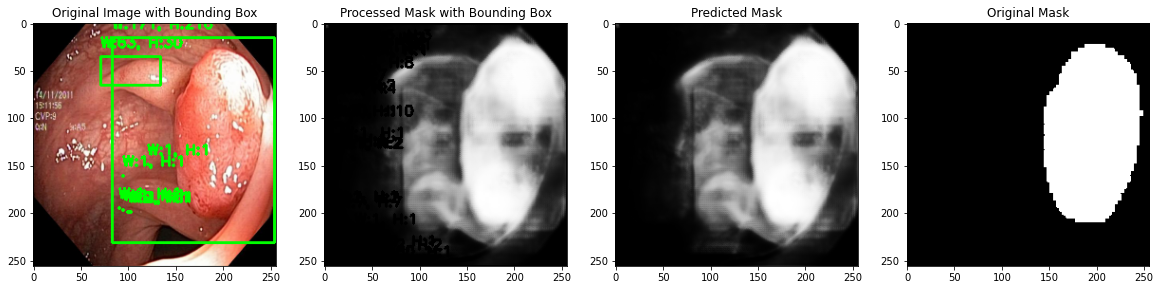

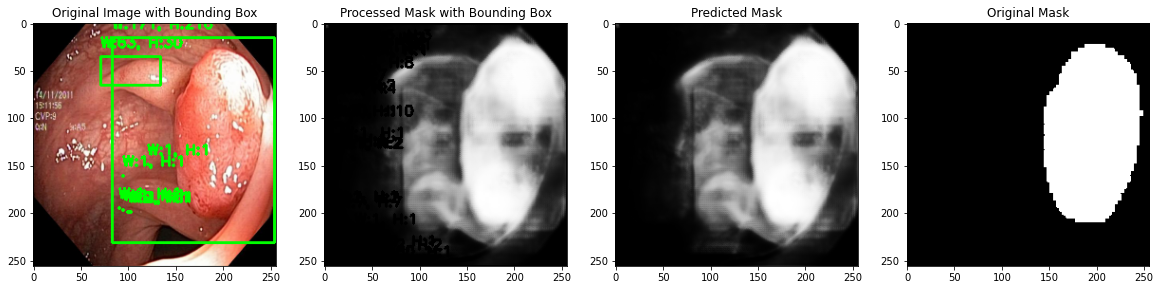

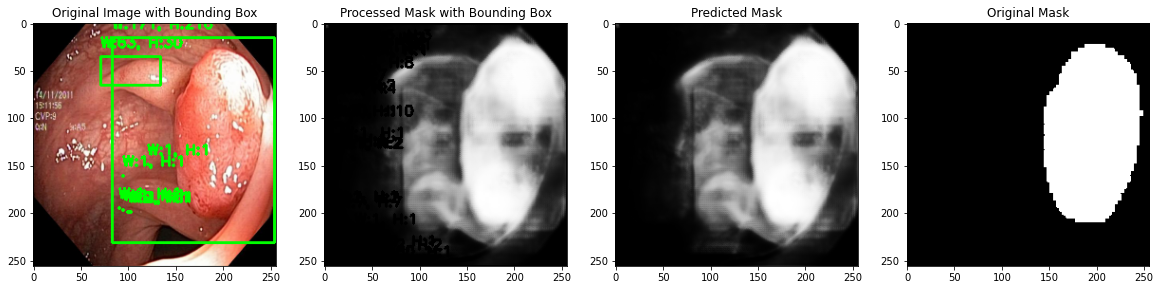

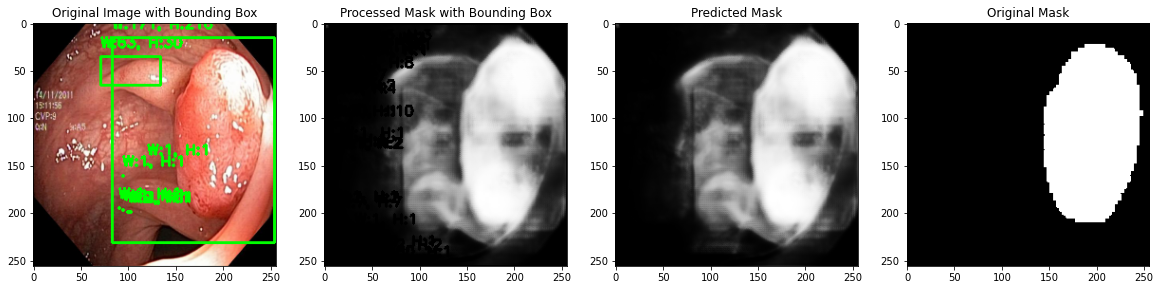

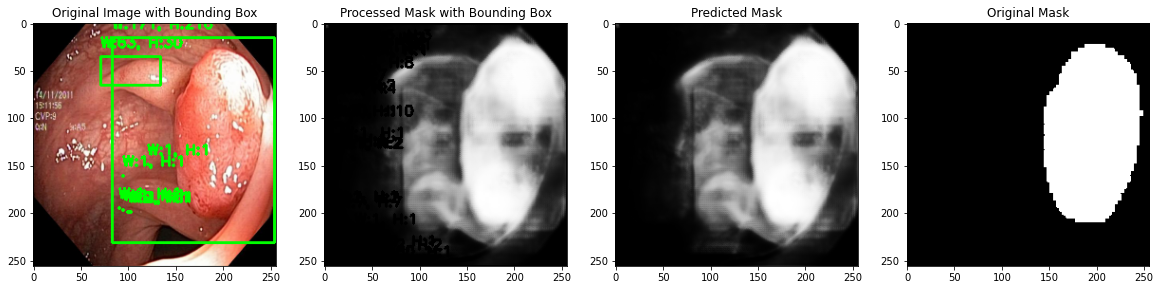

In [1]:
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
IMG_CHANNELS = 3
IMG_WIDTH = 256
IMG_HEIGHT = 256
images_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
mask_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"
img_ids = next(os.walk(images_path))[2]
mask_ids = next(os.walk(mask_path))[2]
X = np.zeros((len(img_ids), 256, 256, 3), dtype=np.uint8)
y = np.zeros((len(mask_ids), 256, 256, 1), dtype=np.bool_)
for n,img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image
for n,mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask
image_random = random.randint(0, len(X))
imshow(X[image_random])
plt.show()
plt.imshow(np.squeeze(y[image_random]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"X_train.shape: {X_train.shape}\nY_train.shape: {y_train.shape}")
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

model = tf.keras.Model(inputs=[input], outputs=[outputs])

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef])
model.summary()
model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=50)

# Function to draw bounding box
def draw_bounding_box(image, mask):
    # Convert mask to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding box for each contour
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f"W:{w}, H:{h}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image

# Function to draw bounding box on mask
def draw_bounding_box_on_mask(mask):
    # Convert mask to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding box for each contour
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        mask = cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(mask, f"W:{w}, H:{h}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return mask

# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

plt.figure(figsize=(20, 12))
plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box")
plt.imshow(img_with_box)
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box")
plt.imshow(mask_with_box, cmap='gray')
plt.subplot(1, 4, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')
plt.subplot(1, 4, 4)
plt.title("Original Mask")
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.show()

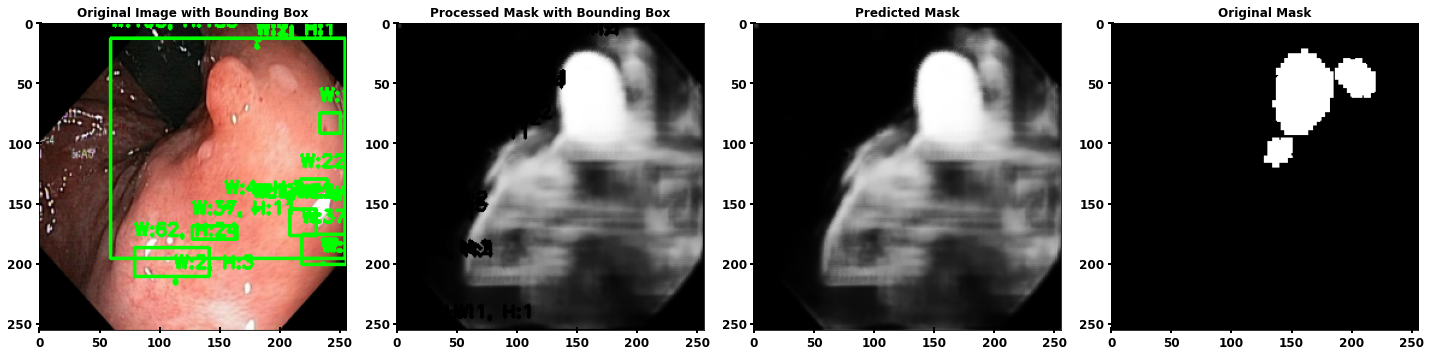

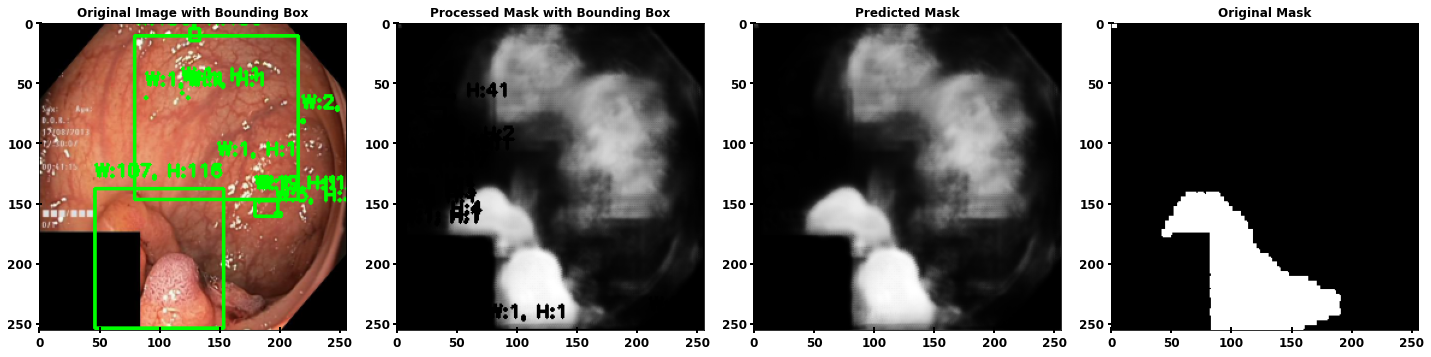

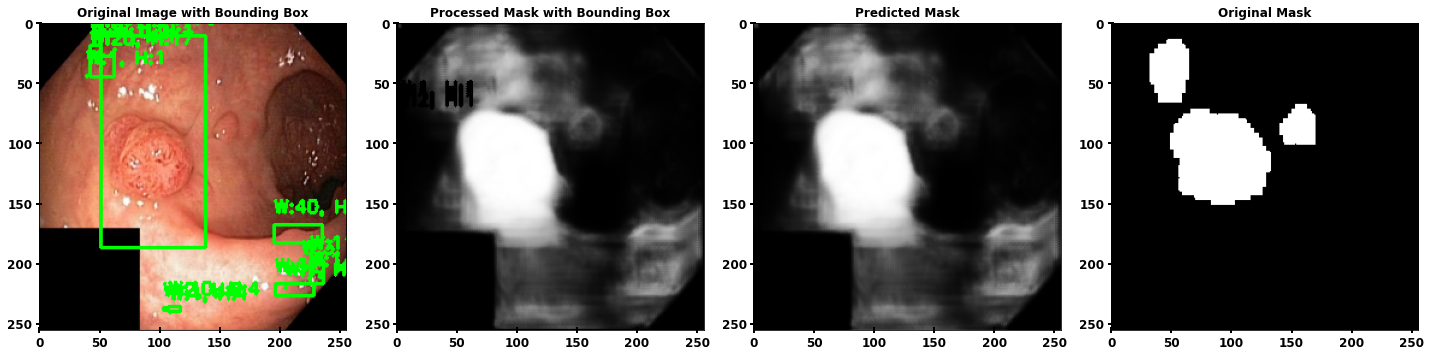

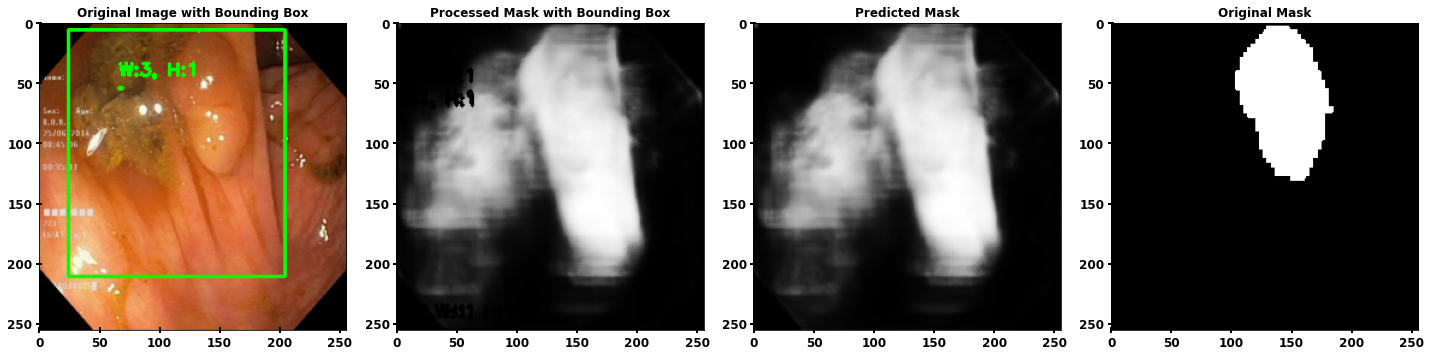

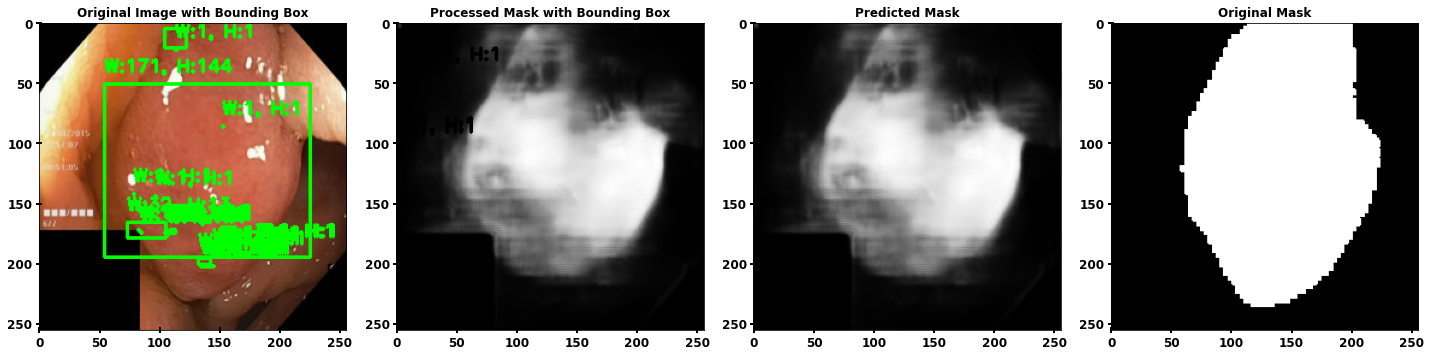

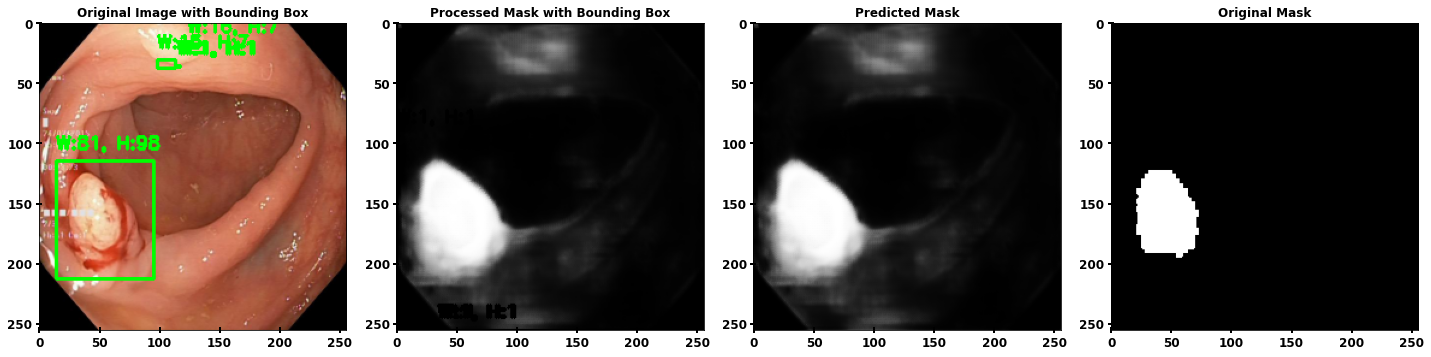

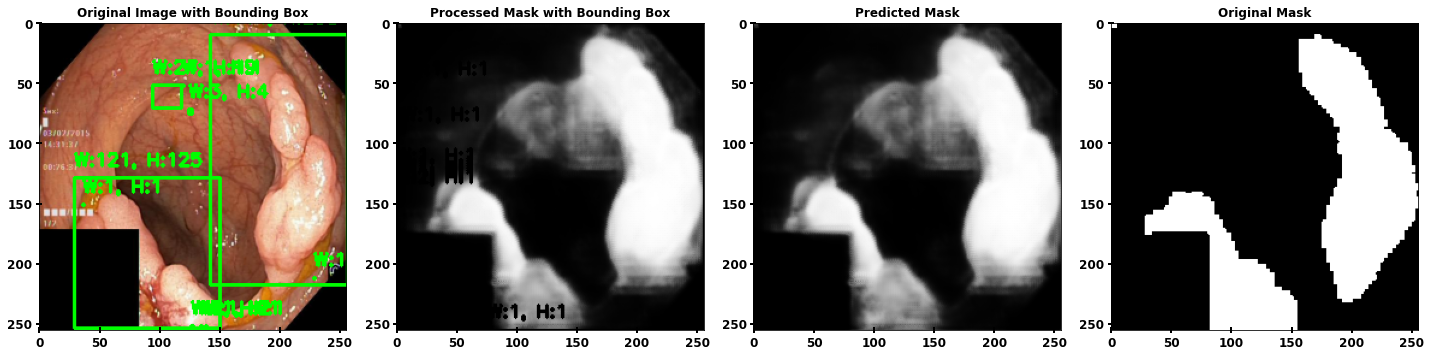

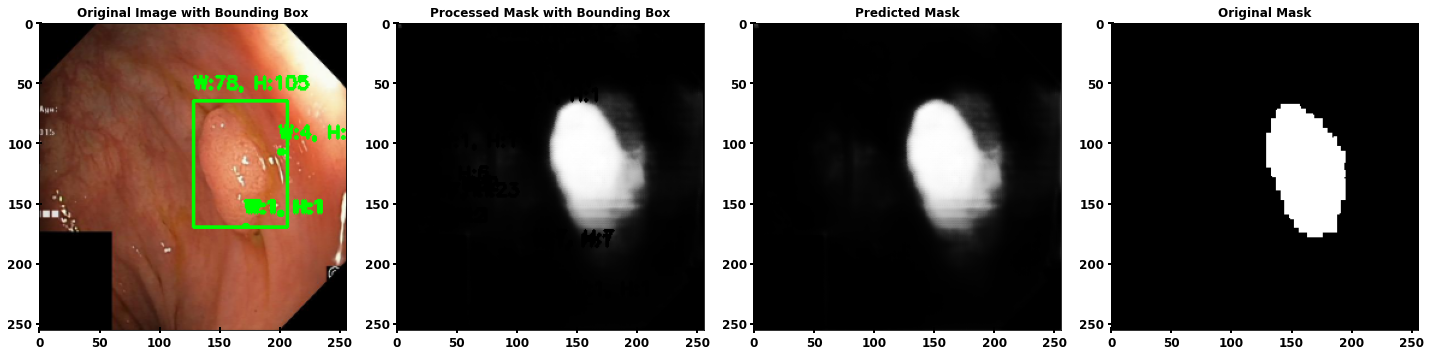

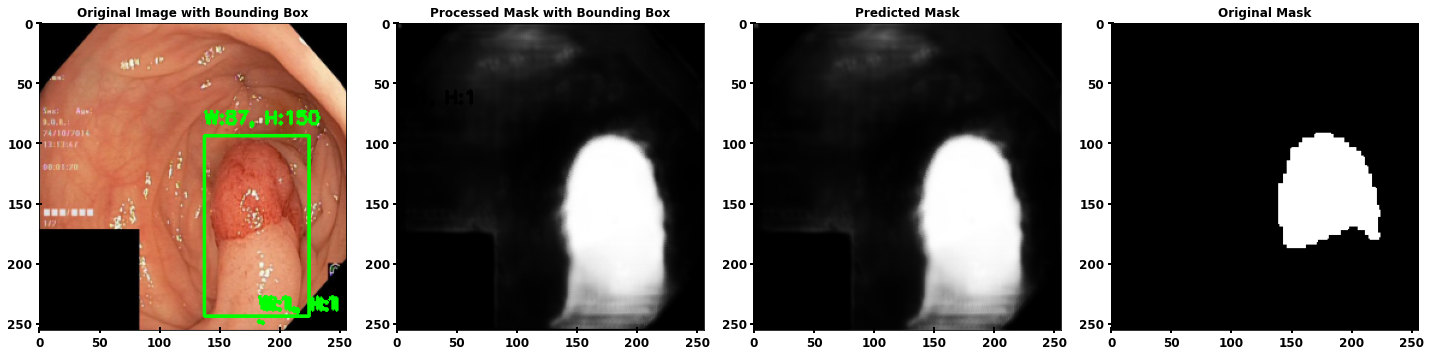

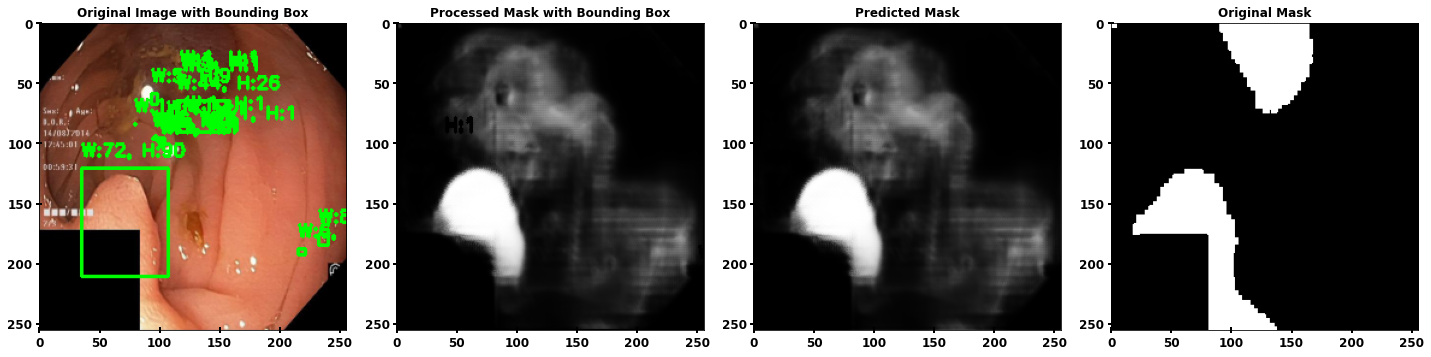

In [8]:
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()
# Predict and visualize
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
pred_mask = np.squeeze(predictions)

# Draw bounding box on the original image and processed mask
img_with_box = draw_bounding_box(np.copy(img), pred_mask)
mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

# Set bold font for all plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

plt.figure(figsize=(20, 12))

plt.subplot(1, 4, 1)
plt.title("Original Image with Bounding Box", fontweight='bold')
plt.imshow(img_with_box)
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 2)
plt.title("Processed Mask with Bounding Box", fontweight='bold')
plt.imshow(mask_with_box, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 3)
plt.title("Predicted Mask", fontweight='bold')
plt.imshow(pred_mask, cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks
plt.subplot(1, 4, 4)
plt.title("Original Mask", fontweight='bold')
plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
plt.axis('on')  # Show axis ticks
plt.tick_params(axis='both', which='both', labelsize=12, width=2, length=6, direction='inout')  # Customize ticks

plt.tight_layout()
plt.show()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 256, 256, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_68[0][0]                  
____________________________________________________________________________________________

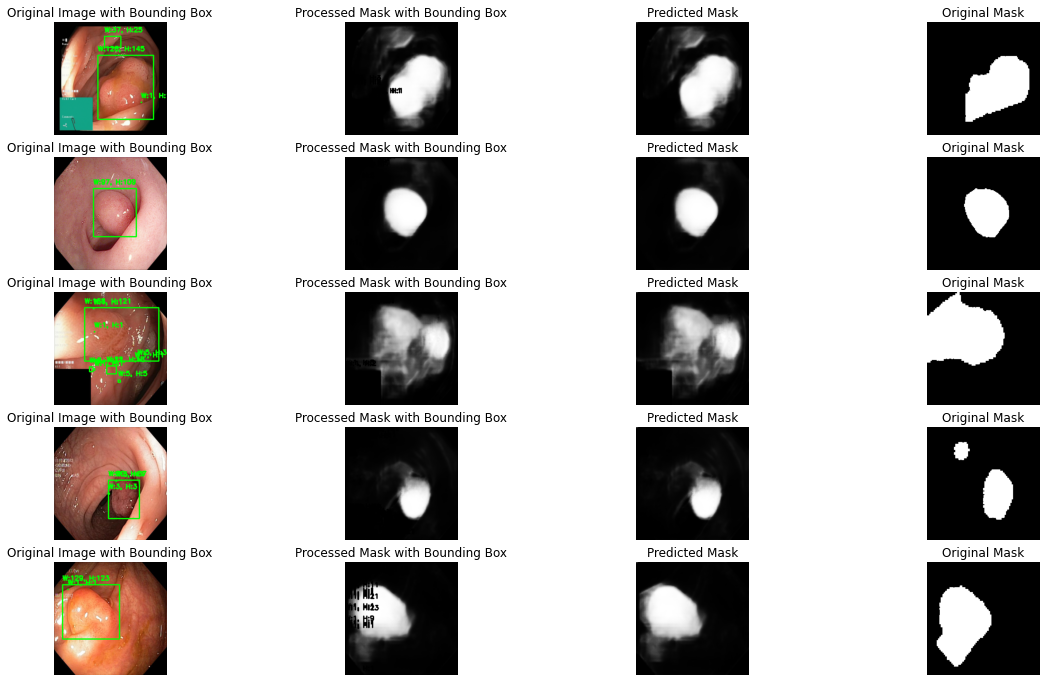

In [4]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Constants
IMG_CHANNELS = 3
IMG_WIDTH = 256
IMG_HEIGHT = 256
images_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
mask_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"

# Loading data
img_ids = next(os.walk(images_path))[2]
mask_ids = next(os.walk(mask_path))[2]

X = np.zeros((len(img_ids), 256, 256, 3), dtype=np.uint8)
y = np.zeros((len(mask_ids), 256, 256, 1), dtype=np.bool_)

for n, img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image

for n, mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# UNet model
input = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

model = tf.keras.Model(inputs=[input], outputs=[outputs])

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef])
model.summary()
model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=50)

# Function to draw bounding box
def draw_bounding_box(image, mask):
    # Convert mask to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding box for each contour
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f"W:{w}, H:{h}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image

# Function to draw bounding box on mask
def draw_bounding_box_on_mask(mask):
    # Convert mask to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding box for each contour
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        mask = cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(mask, f"W:{w}, H:{h}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return mask

# Predict and visualize on 10 random images
num_images = 5
indices = random.sample(range(len(X_test)), num_images)

plt.figure(figsize=(20, 12))
for i, ind in enumerate(indices):
    img = X_test[ind]
    predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_mask = np.squeeze(predictions)

    # Draw bounding box on the original image and processed mask
    img_with_box = draw_bounding_box(np.copy(img), pred_mask)
    mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

    plt.subplot(num_images, 4, 4*i + 1)
    plt.title("Original Image with Bounding Box")
    plt.imshow(img_with_box)
    plt.axis('off')

    plt.subplot(num_images, 4, 4*i + 2)
    plt.title("Processed Mask with Bounding Box")
    plt.imshow(mask_with_box, cmap='gray')
    plt.axis('off')

    plt.subplot(num_images, 4, 4*i + 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_images, 4, 4*i + 4)
    plt.title("Original Mask")
    plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
    plt.axis('off')

plt.show()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
______________________________________________________________________________________________

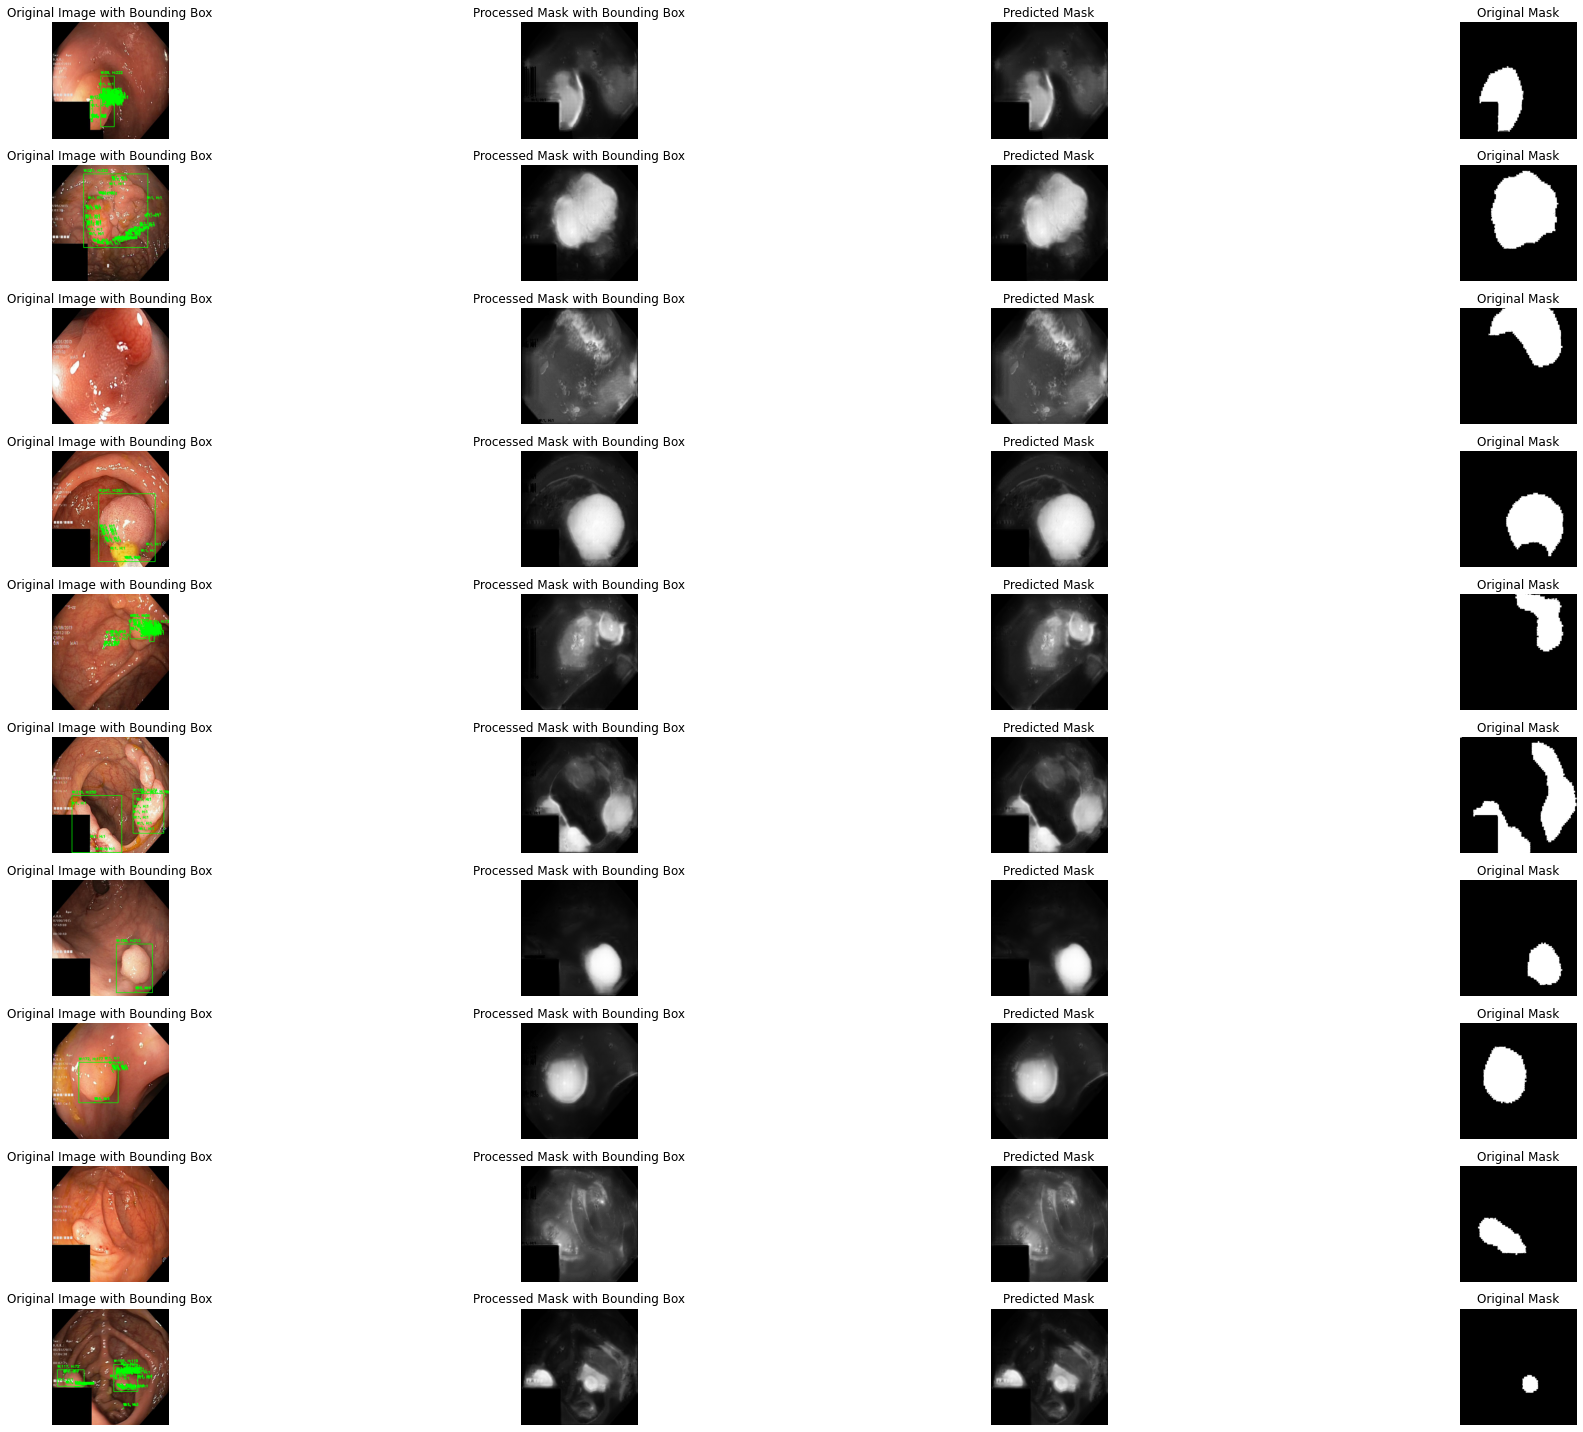

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow.keras import backend as K

# Constants
IMG_CHANNELS = 3
IMG_WIDTH = 512  # Increased size for better visualization
IMG_HEIGHT = 512  # Increased size for better visualization
images_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
mask_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"

# Loading data
img_ids = next(os.walk(images_path))[2]
mask_ids = next(os.walk(mask_path))[2]

X = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
y = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

for n, img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
    X[n] = image

for n, mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# UNet model
input = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

model = tf.keras.Model(inputs=[input], outputs=[outputs])

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef])
model.summary()
model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=50)

# Function to draw bounding box
def draw_bounding_box(image, mask):
    # Convert mask to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding box for each contour
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f"W:{w}, H:{h}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return image

# Function to draw bounding box on mask
def draw_bounding_box_on_mask(mask):
    # Convert mask to binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding box for each contour
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        mask = cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(mask, f"W:{w}, H:{h}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return mask

# Predict and visualize on 10 random images
num_images = 10
indices = random.sample(range(len(X_test)), num_images)

plt.figure(figsize=(30, 20))  # Larger figure size

for i, ind in enumerate(indices):
    img = X_test[ind]
    predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_mask = np.squeeze(predictions)

    # Draw bounding box on the original image and processed mask
    img_with_box = draw_bounding_box(np.copy(img), pred_mask)
    mask_with_box = draw_bounding_box_on_mask((pred_mask * 255).astype(np.uint8))

    plt.subplot(num_images, 4, 4*i + 1)
    plt.title("Original Image with Bounding Box")
    plt.imshow(img_with_box)
    plt.axis('off')

    plt.subplot(num_images, 4, 4*i + 2)
    plt.title("Processed Mask with Bounding Box")
    plt.imshow(mask_with_box, cmap='gray')
    plt.axis('off')

    plt.subplot(num_images, 4, 4*i + 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_images, 4, 4*i + 4)
    plt.title("Original Mask")
    plt.imshow(np.squeeze(y_test[ind]), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

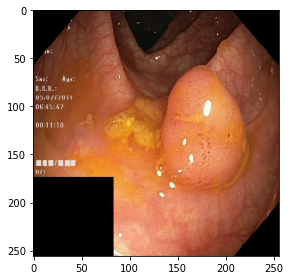

X_train.shape: (670, 256, 256, 3)
Y_train.shape: (670, 256, 256, 1)


NameError: name 'dice_coefficient' is not defined

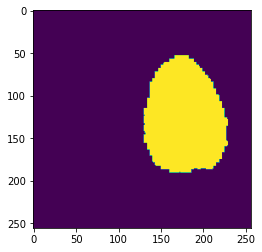

In [1]:
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Constants
IMG_CHANNELS = 3
IMG_WIDTH = 256
IMG_HEIGHT = 256
images_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
mask_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"

# Load Images and Masks
img_ids = next(os.walk(images_path))[2]
mask_ids = next(os.walk(mask_path))[2]

X = np.zeros((len(img_ids), 256, 256, 3), dtype=np.uint8)
y = np.zeros((len(mask_ids), 256, 256, 1), dtype=np.bool_)

for n, img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image

for n, mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

image_random = random.randint(0, len(X))
imshow(X[image_random])
plt.show()
plt.imshow(np.squeeze(y[image_random]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"X_train.shape: {X_train.shape}\nY_train.shape: {y_train.shape}")

# Define U-Net model
input = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# Encoder
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# Decoder
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# Decoder continued
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)

# Output layer
output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c10)

# Define the model
model = tf.keras.models.Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])

# Define Dice Coefficient and IoU metrics
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=8, callbacks=callbacks)

# Plot training history with customized visualization
def plot_history(metric, val_metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], 'o-', linewidth=3, markersize=8, label=f'Training {ylabel}')
    plt.plot(history.history[val_metric], 'o-', linewidth=3, markersize=8, label=f'Validation {ylabel}')
    plt.title(f'Training and Validation {title}', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.savefig(f'{metric}_{val_metric}.png', dpi=300)
    plt.show()

plot_history('accuracy', 'val_accuracy', 'Accuracy', 'Accuracy')
plot_history('loss', 'val_loss', 'Loss', 'Loss')
plot_history('dice_coefficient', 'val_dice_coefficient', 'Dice Coefficient', 'Dice Coefficient')
plot_history('iou', 'val_iou', 'IoU', 'IoU')

# Evaluate the model on the test set
test_loss, test_acc, test_dice, test_iou = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')
print(f'Test Dice: {test_dice}')
print(f'Test IoU: {test_iou}')
